In [210]:
import sys

sys.path.append("slimpajama/py_src/near_duplicates")

In [ ]:
from utils import merge_results, bytes_to_ints
import os
import pickle
from tqdm import tqdm
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import numpy as np
from collections import Counter
import pandas as pd
from utils import edit_distance
from config import DS_PATH, DS_SIZE_PATH, RESULTS_DIR

In [105]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [5]:
with open(DS_SIZE_PATH, "rb") as f:
    ds_size_raw = f.read()
    ds_size = bytes_to_ints(ds_size_raw, 8)

print("loaded sizes")

with open(DS_PATH, "rb") as f:
    ds = f.read()

print("loaded full dataset")

In [ ]:
merged_results_path = os.path.join(RESULTS_DIR, "merged_results.pkl")
if os.path.exists(merged_results_path):
    with open(merged_results_path, "rb") as f:
        results = pickle.load(f)
    print(f"Loaded {len(results)} results from merged_results.pkl")
else:
    total = 0
    results = None

    for filename in tqdm(sorted(os.listdir(RESULTS_DIR))):
        with open(os.path.join(RESULTS_DIR, filename), "rb") as f:
            new_results = pickle.load(f)
        if results is None:
            results = new_results
        else:
            results = merge_results(results, new_results)
        total += 1    
    
    with open(merged_results_path, "wb") as f:
        pickle.dump(results, f)

    print(f"Saved {len(results)} results to merged_results.pkl")

In [107]:
all_buckets = sorted(set([r.bucket for r in results]))

In [ ]:
cum_counts = {}
for bucket in all_buckets:
    results_bucket = [x for x in results if x.bucket == bucket]
    cum_counts_tmp = defaultdict(list)
    for metric in ("hamming", "edit"):
        for dist in range(51):
            cnts = []
            for r in results_bucket:
                near_dups_dist = [x for x in r.near_duplicates[metric] if x[1] <= dist]
                cnt = len(near_dups_dist)
                cnts.append(cnt * 20) # extrapolating total count from 5%
            cum_counts_tmp[metric].append((np.mean(cnts), np.std(cnts)))

    cum_counts[bucket] = cum_counts_tmp

In [ ]:
plt.figure(figsize=(6, 6))
colors = [
    "#006d2c",
    "#31a354",
    "#74c476",
]

csv_data = []

for idx, bucket in enumerate([10000, 1000, 100]):
    results_bucket = [x for x in results if x.bucket == bucket]

    means = [x[0] for x in cum_counts[bucket]["edit"]]
    stds = [x[1] for x in cum_counts[bucket]["edit"]]

    n_samples = len(results_bucket)
    standard_errors = [std / np.sqrt(n_samples) for std in stds]

    for distance in range(51):
        csv_data.append({
            'bucket': bucket,
            'distance': distance,
            'mean': means[distance],
            'se': standard_errors[distance]
        })

    plt.plot(
        range(51),
        means,
        color=colors[idx],
        marker="o",
        markersize=5,
        markeredgecolor="white",
        markerfacecolor=colors[idx],
        markeredgewidth=0.5,
        label="$B_{" + f"{bucket}" + "}$",
    )

    plt.fill_between(
        range(51),
        [m - se for m, se in zip(means, standard_errors)],
        [m + se for m, se in zip(means, standard_errors)],
        color=colors[idx],
        alpha=0.2,
    )

df = pd.DataFrame(csv_data)
df = df.round(2)
df.to_csv('cum_near_duplicates_all_log.csv', sep=';', decimal=',', index=False)

plt.grid(True, linestyle="-", color="#E5E7EB", alpha=0.9, zorder=0)
plt.xlabel("Levenshtein distance", fontsize=16)
plt.tick_params(labelsize=9)

plt.ylabel("Cumulative number of near duplicates", fontsize=16)
plt.legend(fontsize=16, loc="upper left")
plt.yscale("log")
plt.yticks(plt.yticks()[0].tolist() + [100])
plt.ylim(1e1, 1e6)

plt.tight_layout()
plt.savefig("cum_near_duplicates_all_log.pdf", bbox_inches="tight")

plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
bucket = 1000

results_bucket = [x for x in results if x.bucket == bucket]
n_samples = len(results_bucket)

edit_values = [x[0] for x in cum_counts[bucket]["edit"]]
edit_ses = [x[1] / np.sqrt(n_samples) for x in cum_counts[bucket]["edit"]]
hamming_values = [x[0] for x in cum_counts[bucket]["hamming"]]
hamming_ses = [x[1] / np.sqrt(n_samples) for x in cum_counts[bucket]["hamming"]]

# Save plotted data to CSV
plot_data = pd.DataFrame({
    'distance': range(51),
    'levenshtein_values': edit_values,
    'levenshtein_se': edit_ses,
    'hamming_values': hamming_values,
    'hamming_se': hamming_ses
})
plot_data = plot_data.round(2)
plot_data.to_csv('cum_near_duplicates_main.csv', sep=';', decimal=',', index=False)

plt.plot(
    range(51),
    edit_values,
    color="#3B82F6",
    marker="o",
    markersize=5,
    markeredgecolor="white",
    markerfacecolor="#3B82F6",
    markeredgewidth=0.5,
    label="Levenshtein distance",
)

plt.plot(
    range(51),
    hamming_values,
    color="#F97316",
    marker="o",
    markersize=5,
    markeredgecolor="white",
    markerfacecolor="#F97316",
    markeredgewidth=0.5,
    label="Hamming distance",
)

plt.fill_between(
    range(51),
    [v - se for v, se in zip(edit_values, edit_ses)],
    [v + se for v, se in zip(edit_values, edit_ses)],
    color="#3B82F6",
    alpha=0.2,
)

plt.fill_between(
    range(51),
    [v - se for v, se in zip(hamming_values, hamming_ses)],
    [v + se for v, se in zip(hamming_values, hamming_ses)],
    color="#F97316",
    alpha=0.2,
)


plt.axhline(
    y=1000,
    xmin=0,
    xmax=1,
    color="dimgray",
    linestyle="--",
    linewidth=1,
    label="Exact duplicates",
)
plt.yticks(list(plt.yticks()[0]) + [1000])
plt.gca().get_yaxis().get_major_ticks()[-1].label1.set_color("dimgray")


plt.grid(True, linestyle="-", color="#E5E7EB", alpha=0.9, zorder=0)
plt.xlabel("Distance", fontsize=16)
plt.ylim(0, 27 * bucket)
plt.xlim(0, 50)
plt.ylabel("Cumulative number of near duplicates", fontsize=16)
plt.legend(fontsize=16, loc="upper left")
plt.tight_layout()
plt.savefig("cum_near_duplicates_main.pdf", bbox_inches="tight")
plt.show()

## Dedup

In [15]:
def has_ngram_overlap(arr1, arr2, n):
    ngrams1 = set([tuple(arr1[i : i + n]) for i in range(len(arr1) - n + 1)])
    ngrams2 = set([tuple(arr2[i : i + n]) for i in range(len(arr2) - n + 1)])

    return len(ngrams1 & ngrams2) > 0

In [ ]:
words = [len(tokenizer.decode(r.tokens).split(" ")) for r in results]
np.mean(words)

In [ ]:
dedup_results = []
ngrams = range(10, 110, 10)
bucket = 1000

for r in tqdm(results):
    if r.bucket != bucket:
        continue

    new_r = copy.deepcopy(r)
    new_r.near_duplicates_dedup = {}

    for ngram_size in ngrams:
        new_r.near_duplicates_dedup[ngram_size] = defaultdict(list)

    for metric in ("hamming", "edit"):
        for pos, dist in r.near_duplicates[metric]:
            nd_tokens = bytes_to_ints(ds[pos : pos + 200], 2)

            for ngram_size in ngrams:
                if not has_ngram_overlap(r.tokens, nd_tokens, n=ngram_size):
                    new_r.near_duplicates_dedup[ngram_size][metric].append((pos, dist))

    dedup_results.append(new_r)

In [ ]:
cum_counts_dedup = {}

metric = "edit"

for ngram_size in ngrams:
    cum_counts_dedup[ngram_size] = defaultdict(list)
    for bucket in (100, 1000, 10000):
        results_bucket = [x for x in dedup_results if x.bucket == bucket]
        for dist in range(51):
            cnt = 0
            for r in results_bucket:
                cnt += len(
                    [
                        x
                        for x in r.near_duplicates_dedup[ngram_size][metric]
                        if x[1] <= dist
                    ]
                )

            # correction for average
            cnt = (cnt / 100) * 20

            cum_counts_dedup[ngram_size][bucket].append(cnt)

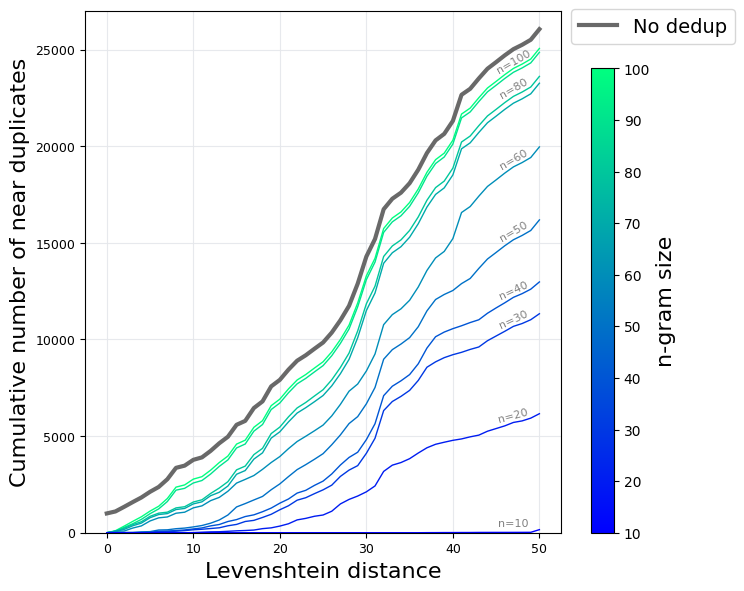

In [22]:
fig, ax = plt.subplots(figsize=(7, 6))
colors = plt.cm.winter(np.linspace(0, 1, 10))
bucket = 1000

plt.plot(
    range(51),
    [x[0] for x in cum_counts[bucket]["edit"]],
    color="dimgrey",
    markersize=5,
    markeredgecolor="white",
    markerfacecolor="dimgrey",
    markeredgewidth=0.5,
    label="No dedup",
    alpha=1.0,
    linewidth=3,
)

for i, ngram_size in enumerate(reversed(ngrams)):
    linewidth = 1.0
    label = None

    plt.plot(
        range(51),
        cum_counts_dedup[ngram_size][bucket],
        linewidth=linewidth,
        color=colors[len(ngrams) - i - 1],
        markersize=5,
        markeredgecolor="white",
        markerfacecolor=colors[i],
        markeredgewidth=0.5,
        label=label,
    )

# Add text annotation for n=10 (bottom line)
plt.text(47, 200, "n=10", fontsize=8, color="grey", ha="center", va="bottom")
plt.text(
    47, 5600, "n=20", fontsize=8, color="grey", ha="center", va="bottom", rotation=15
)
plt.text(
    47, 10500, "n=30", fontsize=8, color="grey", ha="center", va="bottom", rotation=25
)
plt.text(
    47, 12000, "n=40", fontsize=8, color="grey", ha="center", va="bottom", rotation=25
)
plt.text(
    47, 15000, "n=50", fontsize=8, color="grey", ha="center", va="bottom", rotation=30
)
plt.text(
    47, 18700, "n=60", fontsize=8, color="grey", ha="center", va="bottom", rotation=30
)
plt.text(
    47, 22400, "n=80", fontsize=8, color="grey", ha="center", va="bottom", rotation=30
)
plt.text(
    47, 23700, "n=100", fontsize=8, color="grey", ha="center", va="bottom", rotation=30
)


plt.grid(True, linestyle="-", color="#E5E7EB", alpha=0.9, zorder=0)
plt.xlabel("Levenshtein distance", fontsize=16)
plt.tick_params(labelsize=9)
plt.ylim(0, 27 * bucket)

plt.ylabel("Cumulative number of near duplicates", fontsize=16)
plt.tight_layout()

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.winter)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("n-gram size", fontsize=16)
cbar.set_ticks(np.linspace(0, 1, 10))
cbar.set_ticklabels([str(x) for x in range(10, 110, 10)])
cbar.ax.set_position(
    [
        cbar.ax.get_position().x0,
        cbar.ax.get_position().y0,
        cbar.ax.get_position().width,
        cbar.ax.get_position().height * 0.89,
    ]
)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.97), fontsize=14)
plt.savefig("cum_near_duplicates_dedup2.pdf", bbox_inches="tight")

csv_data = {"distance": list(range(51))}
csv_data["no_dedup"] = [x[0] for x in cum_counts[bucket]["edit"]]

for ngram_size in ngrams:
    csv_data[f"n_{ngram_size}"] = cum_counts_dedup[ngram_size][bucket]

df = pd.DataFrame(csv_data)
df = df.round(2)
df.to_csv("cum_near_duplicates_dedup2.csv", index=False, sep=";", decimal=',')

plt.show()